# Import Cell

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,cross_validate , GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix,plot_confusion_matrix , accuracy_score,recall_score,f1_score,precision_score
from sklearn.dummy import DummyClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

# Early EDA

In [27]:
df1 = pd.read_csv('data/Training Set Values.csv')
df2 = pd.read_csv('data/Training Set Labels.csv')
pd.set_option('display.max_columns',None)

In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [29]:
df1.fillna('unknown',inplace=True)

Since all of our null values are objects, we filled them in as unknown for now so we can keep the whole dataset. We also need to join the labels and train set on ID.

In [30]:
# Here we add the status of the pumps into our main DF
dic = dict(zip(df2['id'],df2['status_group']))
df1['status'] = df1['id'].map(dic)

# Look at the distribution of our target values
df = df1.loc[df1['status'] == 'functional']
len(df) / len(df1)

non_sum = len(df1.loc[df1['status'] == 'non functional']) / len(df1) 
funciontal_sum = len(df) / len(df1) 
needs_repairs = 1-(non_sum+funciontal_sum)
needs_repairs
print(f'''Percent of functional: {round(funciontal_sum*100,2)}
Percent of non functional: {round(non_sum*100,2)}
Percent of pumps needing repairs: {round(needs_repairs*100,2)}
''')

Percent of functional: 54.31
Percent of non functional: 38.42
Percent of pumps needing repairs: 7.27



Since functional needs repairs only makes up 7% of our dataset, we have decided to convert this value to functional for easier modelling. This puts our target value at roughly a 62 to 38 percent distribution.

In [31]:
#binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
#df1['status'].replace(binary_key, inplace=True)

Here we convert our functional / non functional to a binary value.

In [32]:

print(f'''Scheme name values: {df1['scheme_name'].unique()} 

Scheme management values: {df1['scheme_management'].unique()}''')
df1.drop(['num_private','public_meeting','scheme_name','id'],axis=1,inplace=True)

Scheme name values: ['Roman' 'unknown' 'Nyumba ya mungu pipe scheme' ... 'BL Nsherehehe'
 'Magati  gravity spri' 'Mtawanya'] 

Scheme management values: ['VWC' 'Other' 'unknown' 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']


Dropping columns we do not think that will not hold any value. 
Num_private is an undefined column with all zeroes.
Public meeting is defined as a True/False value in our column description and gives no indication to what it means.
id is simply the ID of the pump we used to join our dataframes on.
Scheme name seems to be similar to scheme management. 

In [33]:
source , source_class, source_type =df1['source'].unique() , df1['source_class'].unique() , df1['source_type'].unique()

print(f'''
Source Values: {source}

Source_class Values: {source_class}

Source_type Values: {source_type}''')

#Drop the columnd we will not use from our DF
df1.drop(['source_type'],axis=1,inplace=True)


Source Values: ['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']

Source_class Values: ['groundwater' 'surface' 'unknown']

Source_type Values: ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']


We have decided to keep Source Values and Source class Values as we think they will provide the most value to our model. The source type values column is a less specific version of the source values column.

In [34]:
extraction_type, extraction_type_group, extraction_type_class = df1['extraction_type'].unique() , df1['extraction_type_group'].unique() , df1['extraction_type_class'].unique()

print(f'''
Extraction Type Values: {extraction_type}

Extraction Type Group Values: {extraction_type_group}

Extraction Type Class: {extraction_type_class}''')

#Drop the columnd we will not use from our DF
df1.drop(['extraction_type_group','extraction_type_class'],inplace = True,axis=1)


Extraction Type Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']

Extraction Type Group Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']

Extraction Type Class: ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


We have decided to keep the extraction type column as we think they will provide the most value to our model. The other two columns are a similar to the extraction values column but more vague.

In [35]:
len(df1['wpt_name'].unique())

37400

This column is the name of the water point which does not help us in our model. Subvillage, lga and ward are also listed as geographic information, but gives us no information we find that is useful. Region is also a more vague version of region id. 

In [36]:
#Drop selected columns
df1.drop(['wpt_name','subvillage','lga','ward','region'],axis=1,inplace=True)

In [37]:

print(f'''Waterpoint Type Group values:{df1['waterpoint_type_group'].unique()} , 

Waterpoint type values: {df1['waterpoint_type'].unique()}''')

df1.drop(['waterpoint_type_group'],axis=1,inplace=True)

Waterpoint Type Group values:['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam'] , 

Waterpoint type values: ['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']


The waterpoint type column is a more specific version of the waterpoint type group. The group values column does not have the multiple standpipe option. We drop the waterpoint type group to use in our dataset. The date recorded column is just when the data was entered into the spreadsheet.

In [38]:
vals = df1['construction_year'].value_counts()
vals[:2]

0       20709
2010     2645
Name: construction_year, dtype: int64

For the construction year column, we have a little over 20,000 values with missing data.The next highest value is 2010, with 2645 wells! We fill in the missing data with the median for the construction year, then make an age column for the pumps and drop the date recorded colum. We are assuming the age of the pump from the time the data was entered into the spreadsheet.

In [39]:
# Fill in the zeroes with median of the year column

#Find median of column
#median_no_zero = int(df1[df1['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
#df1.loc[(df1['construction_year'] == 0),'construction_year'] = median_no_zero
#df1.loc[(df1['construction_year'] > df1['date_recorded'].str[:4].astype(int)),'construction_year'] = median_no_zero
#Subtract construction year from date recorded
#df1['age'] = df1['date_recorded'].str[:4].astype(int) - df1['construction_year']


In [40]:
# We drop the date recorded column as we no longer need it
#df1.drop('date_recorded',axis=1,inplace=True)

KeyError: 'age'

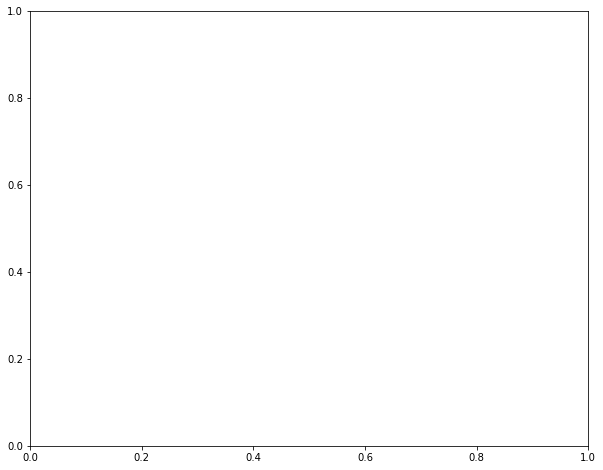

In [70]:
fig , ax = plt.subplots(figsize=(10,8))

sns.histplot(df1['age'])
ax.set_title('Age',fontsize=16)
ax.set_xlabel('Age of Pump',fontsize=16)
ax.set_ylabel('Count of Values',fontsize=16);

This gives us a large amount of values at the age of 11, but we hope this will help our model make predictions instead of discarding these values.

In [42]:
# Converts this column from boolean to string
df1['permit'] = df1['permit'].astype(str)

In [43]:
#makes a copy of df that has not been converted to binary values for target
df_non_binary = df1.copy()

# Apply the binary function to our target.
binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
df1['status'].replace(binary_key, inplace=True)

In [44]:
df1.loc[(df1['status'] == 1)].value_counts(['extraction_type'])        

extraction_type          
gravity                      8031
other                        5195
nira/tanira                  2092
submersible                  1911
mono                         1654
swn 80                       1368
india mark ii                 873
ksb                           686
afridev                       528
other - rope pump             141
other - swn 81                102
windmill                       60
other - play pump              55
india mark iii                 53
cemo                           36
climax                         24
walimi                         13
other - mkulima/shinyanga       2
dtype: int64

The highest number of failed extraction types seem to be gravity. Let's get a better look at how all of the pumps do.

In [45]:
def percent_dict(column):
    percent= []
    lst = list(df1[column].unique())
    for val in lst:
        num_pumps = len(df1.loc[df1[column] == val])
        fail_pumps = len(df1.loc[(df1['status'] == 1) & (df1[column] == val)])
        percent.append(round((fail_pumps/num_pumps*100),2))     
    d = dict(zip(lst,percent))
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return d_sorted

In [46]:

#Percent of failures for pumps:
percent_dict('extraction_type')

{'other - mkulima/shinyanga': 100.0,
 'other': 80.79,
 'climax': 75.0,
 'other - play pump': 64.71,
 'mono': 57.73,
 'india mark iii': 54.08,
 'windmill': 51.28,
 'ksb': 48.48,
 'other - swn 81': 44.54,
 'submersible': 40.11,
 'cemo': 40.0,
 'swn 80': 37.28,
 'india mark ii': 36.38,
 'other - rope pump': 31.26,
 'gravity': 29.99,
 'afridev': 29.83,
 'walimi': 27.08,
 'nira/tanira': 25.66}

The highest percent of failures seem to come from extraction types mkulima/shinyanga, climax, and play pumps. So while gravity has a high number of failed extraction types, it ranks low in overall failures.

In [47]:
df1.loc[(df1['status'] == 1)].value_counts(['water_quality'])   

water_quality     
soft                  18154
salty                  2411
unknown                1577
milky                   352
coloured                190
salty abandoned          93
fluoride                 36
fluoride abandoned       11
dtype: int64

Here we see soft water has the highest number of failures. This looks like the number is high because it is also the most common water type. We would expect water with higher solid contents (such as saltwater) to have a high percent of failures because of the wear and tear caused by the solids in the water. 

In [48]:
percent_dict('water_quality')

{'unknown': 84.06,
 'fluoride abandoned': 64.71,
 'salty': 49.65,
 'milky': 43.78,
 'coloured': 38.78,
 'soft': 35.72,
 'salty abandoned': 27.43,
 'fluoride': 18.0}

Just as we thought, soft water is in the lower percentage of failures. Saltwater pumps are in the higher percentage range for failures, while abondoned saltwater pumps have a lower failure rate. Unknown water types take the lead for failures. It would be interesting to see the solid content percent of those unknown water types, as we think more solids in the water leads to more failures. Other things (like flow rates) would affect the failures also. The faster the solids move in water, the more damage they will do to pumps!  

In [49]:
len(df1.loc[df1['water_quality'] == 'salty abandoned']) , len(df1.loc[(df1['status'] == 1) & (df1['water_quality'] == 'salty abandoned')])

(339, 93)

# Model Development

In [50]:
#Prepare function to get metrics
def metrics(y_test,y_preds):
    return print(f'''Recall Score: {recall_score(y_test,y_preds)}
Precision Score: {precision_score(y_test,y_preds)}
Accuracy Score:{accuracy_score(y_test,y_preds)}
F1 Score: {f1_score(y_test,y_preds)}
Matrix: 
{confusion_matrix(y_test,y_preds)}''')

In [51]:
# Create a dummy model for starting point
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

dummy_model = DummyClassifier(strategy="most_frequent")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)


cv_results = cross_validate(dummy_model, X_train, y_train, return_train_score=True)

print(f'''Dummy Accuracy Score: {cv_results['test_score'].mean()}''')

Dummy Accuracy Score: 0.6157575757575758


# KNN Model

In [52]:
# Prepare for testing
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

In [99]:
#Split our data. We stratify Y to make sure the split is balanced.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)
y_test.replace(binary_key,inplace=True)

In [100]:
# Find median of column
median_no_zero = int(X_train[X_train['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_no_zero
X_train.loc[(X_train['construction_year'] > X_train['date_recorded'].str[:4].astype(int)),'construction_year'] = median_no_zero
#Subtract construction year from date recorded
X_train['age']=X_train['date_recorded'].str[:4].astype(int) - X_train['construction_year']
#Drop Date recorded
X_train.drop('date_recorded',axis=1,inplace=True)

In [101]:
median_no_zero = int(X_test[X_test['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_test.loc[(X_test['construction_year'] == 0),'construction_year'] = median_no_zero
X_test.loc[(X_test['construction_year'] > X_test['date_recorded'].str[:4].astype(int)),'construction_year'] = median_no_zero
#Subtract construction year from date recorded
X_test['age']=X_test['date_recorded'].str[:4].astype(int) - X_test['construction_year']
#Drop Date recorded
X_test.drop('date_recorded',axis=1,inplace=True)

In [103]:
#Split columns into number and objects
categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

#Prepare pipeline steps for each of the column types
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# col_trans = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#                               remainder='passthrough')

# Set up column transformer to plug into our pipeline
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Set up our pipeline and use a KNN model first.
base_pipline = Pipeline(steps=[('trans', trans),
                              ('model', KNeighborsClassifier())])

#cv = cross_validate(base_pipline, X_train, y_train, return_train_score=True)


In [104]:
print(f'''Mean of Test Scores:{cv['test_score'].mean()}
Mean of Training Scores: {cv['train_score'].mean()}''')

Mean of Test Scores:nan
Mean of Training Scores: nan


Our model has good bias for a first model, which we will consider low. Our variance is a little high. Our model is overfit.

In [74]:
# Use GridSearch in order to find the best parameters for our model

grid= {'model__n_neighbors': [5,7,11,15,21],
      'model__weights': ['distance','uniform'],
      }

gs = GridSearchCV(base_pipline,grid,cv=3)
gs.fit(X_train,y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown=...
                                                                         Index(['funder', 'i

In [83]:
#gs.score(X_train,y_train)
#cv = cross_validate(gs, X_train, y_train, return_train_score=True)

In [81]:
gs.best_params_ , gs.best_score_ 

({'model__n_neighbors': 21, 'model__weights': 'distance'}, 0.8275196408529742)

Gridsearch improved our accuracy score by a small amount. The best number of neighbors is 21 and distance our best weight. We still have a moderate amount of variance in our model.

In [102]:
base_pipline.fit(X_train,y_train)

y_preds = base_pipline.predict(X_test)

metrics(y_test,y_preds)

Recall Score: 0.7367683140553803
Precision Score: 0.82109375
Accuracy Score:0.8371717171717171
F1 Score: 0.7766488084241642
Matrix: 
[[8228  916]
 [1502 4204]]


44614    non functional
42868        functional
24507        functional
35407    non functional
48257        functional
              ...      
47318        functional
5889     non functional
31477    non functional
4690         functional
55829    non functional
Name: status, Length: 14850, dtype: object

In [105]:
plot_confusion_matrix(base_pipline,X_test,y_test)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Logistic Model

Here we will try another model, going with logistic this time. We will follow a similar process as last time with pipeline. We will change the model type and the hyper parameters in grid search.

In [106]:
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)

In [107]:

categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# col_trans = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#                               remainder='passthrough')

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Change model type and hyper parameters

base_pipline = Pipeline(steps=[('trans', trans),
                              ('model', LogisticRegression(random_state=42))])


grid = {'model__C' : [0.5, 1, 50],
       'model__max_iter' : [1750, 2000],
       'model__class_weight': [None, 'balanced', 0.25],
       'model__tol' : [0.0001, 0.01, 0.1]}

gs = GridSearchCV(base_pipline, grid, cv=3)

In [108]:
gs.fit(X_train, y_train)

KeyboardInterrupt: 

Our score is a little worse than the KNN model.

In [828]:
cv = cross_validate(base_pipline, X_train, y_train, return_train_score=True)
cv['train_score'].mean() , cv['test_score'].mean()

C:\Users\mmcel\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mmcel\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

(0.8223849607182941, 0.8118742985409652)

This model does have low variance with similar bias to our KNN model. Our overfitting problem seems to be fixed.